In [1]:
def kel_to_grad(a):
    return (a - 273.15)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

la = 54.25
lo = 48.29
year_data = {}
i = 2019
for i in tqdm(range(2019,2022)):
    ds = xr.open_dataset(f'data/grib/{i}.grib', engine='cfgrib');
    data = ds.sel(latitude=la)
    data = data.sel(longitude=lo)
    df = data.to_dataframe()
    df = df.drop(['number','step','surface','latitude','longitude','valid_time','v10n'],axis=1)
    df.t2m = df.t2m.apply(kel_to_grad)
    df['ws'] = np.sqrt(np.square(df.u10)+np.square(df.v10))
    df['wd'] = np.arctan2(df.v10,df.u10)
    year_data[i] = df;

  0%|          | 0/3 [00:00<?, ?it/s]skipping variable: paramId==228219 shortName='lsrr'
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\envs\WindDataPreporation2\lib\site-packages\cfgrib\dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "C:\Users\admin\anaconda3\envs\WindDataPreporation2\lib\site-packages\cfgrib\dataset.py", line 609, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1546300800, 1546304400, 1546308000, ..., 1577826000, 1577829600,
       1577833200])) new_value=Variable(dimensions=('time',), data=array([1546279200, 1546322400, 1546365600, 1546408800, 1546452000,
       1546495200, 1546538400, 1546581600, 1546624800, 1546668000,
       1546711200, 1546754400, 1546797600, 1546840800, 1546884000,
       1546927200, 1546970400, 1547013600, 154705680

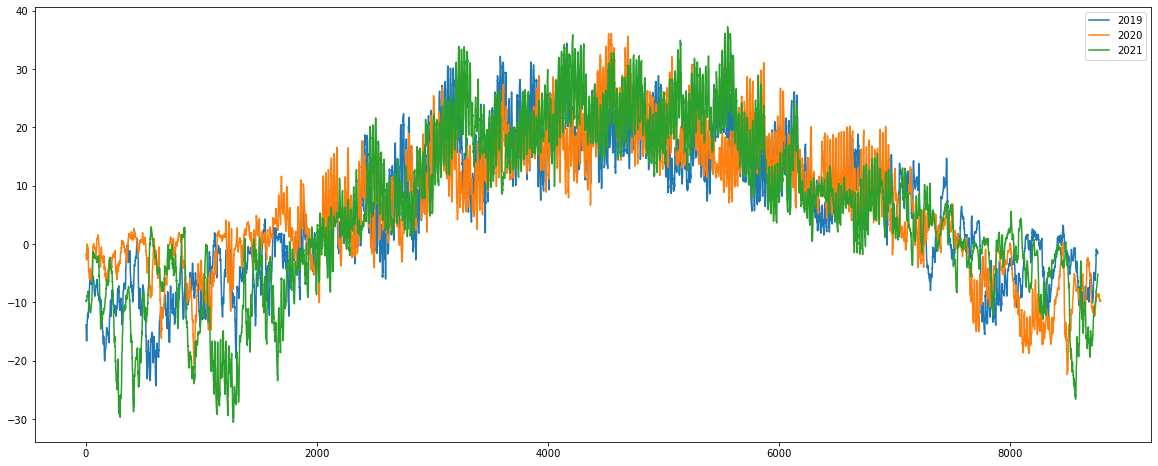

<Figure size 1728x576 with 0 Axes>

In [3]:
plt.rcParams['figure.figsize'] = [20, 8]

fig, ax = plt.subplots()
plt.figure(figsize=(24, 8))
for k,v in year_data.items():
    ax.plot(range(len(v.t2m)), v.t2m,label=k)
ax.legend()

In [4]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [5]:
fit1 = SimpleExpSmoothing(year_data[2019].t2m, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fit1.model.params['smoothing_level']

C:\Users\admin\anaconda3\envs\WindDataPreporation2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.2

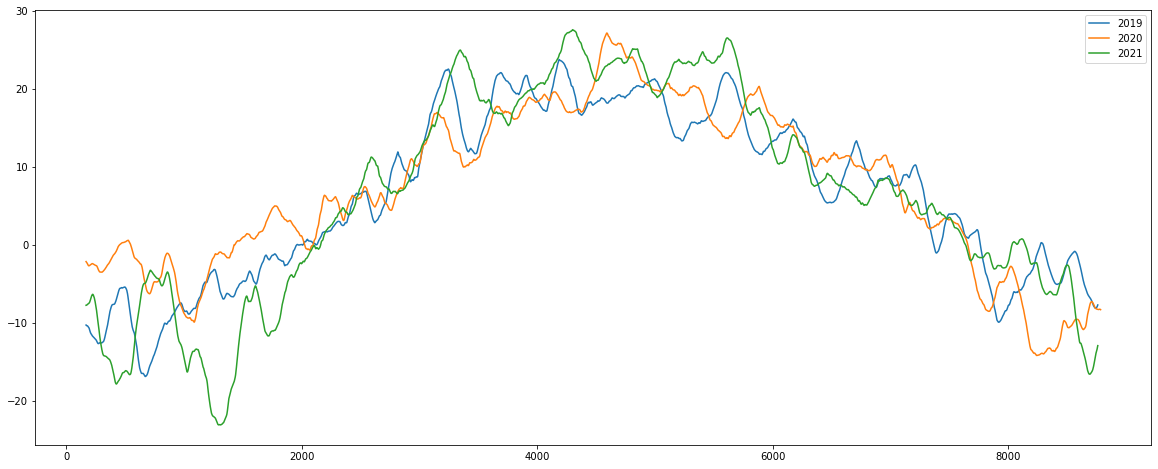

<Figure size 1728x576 with 0 Axes>

In [6]:
plt.rcParams['figure.figsize'] = [20, 8]

fig, ax = plt.subplots()
plt.figure(figsize=(24, 8))
for k,v in year_data.items():
    ax.plot(range(len(v.t2m)), v.t2m.rolling(window=24*7).mean(),label=k)
ax.legend()

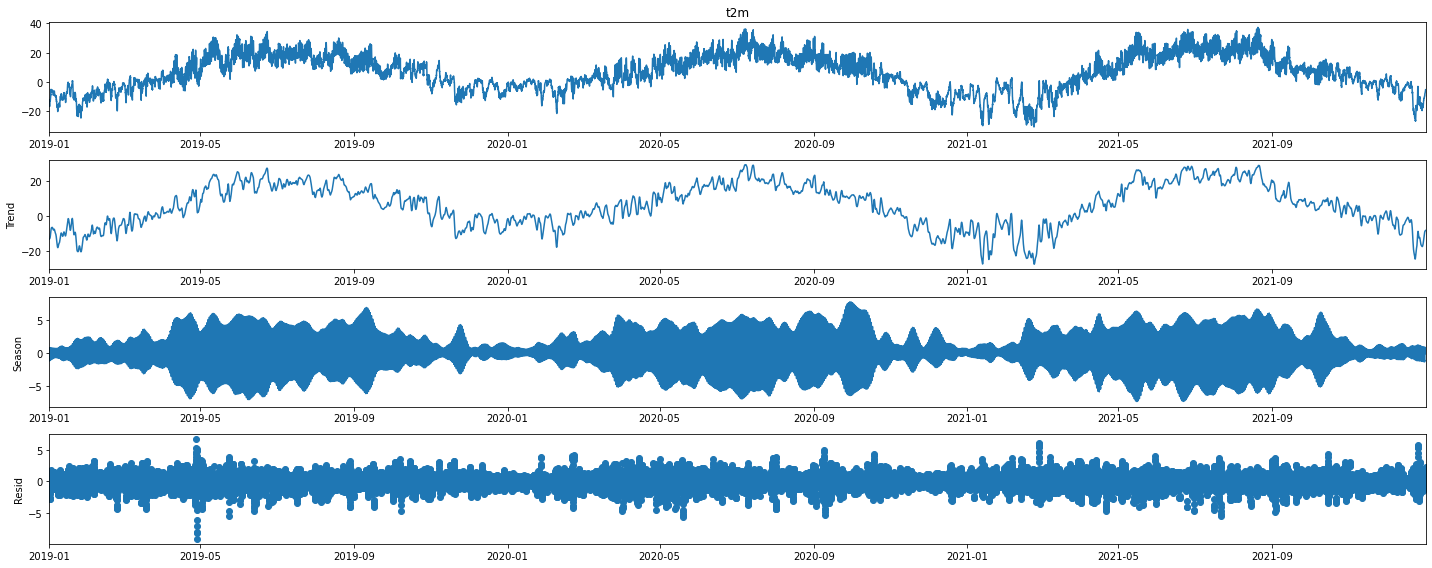

In [7]:
from statsmodels.tsa.seasonal import STL

stl = STL(pd.concat([v.t2m for k,v in year_data.items()]), seasonal=13)
res = stl.fit()
fig = res.plot()

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(pd.concat([v.t2m for k,v in year_data.items()]),lags=18000);

C:\Users\admin\anaconda3\envs\WindDataPreporation2\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


KeyboardInterrupt: 

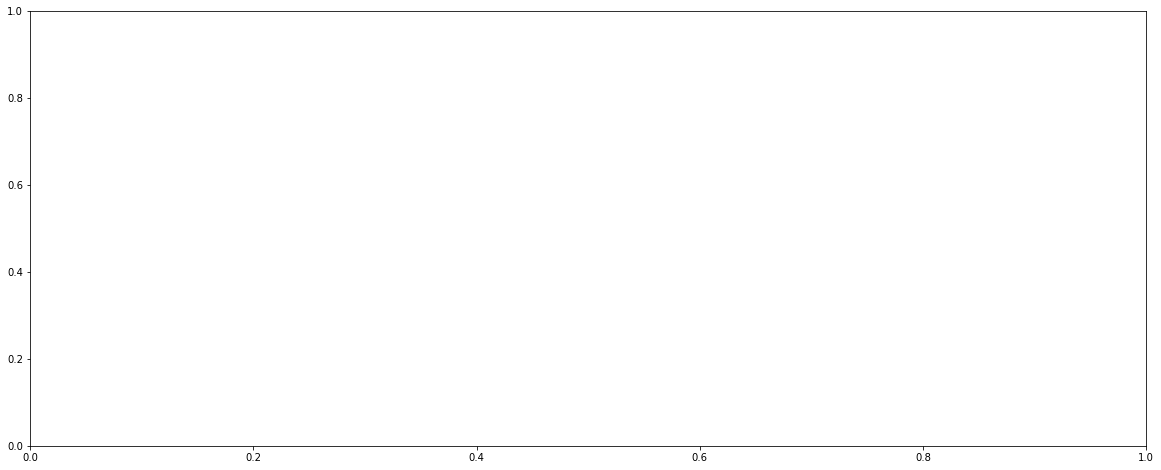

In [11]:
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf(pd.concat([v.t2m for k,v in year_data.items()]),lags=13000);